In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re
import seaborn as sns
import plotly
from os import listdir

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))

In [75]:
data_folder = 'data'
broadband = 'broadband.csv'
broadband_zip = 'broadband_zip.csv'

bband = pd.read_csv(Path(data_folder) / broadband)
bband_zip = pd.read_csv(Path(data_folder) / broadband_zip)

for df in [bband, bband_zip]:
    df.columns = [str.lower(str.replace(col, ' ', '_')) for col in df.columns]
    df.columns = [re.sub('\+\/\-', '', re.sub('\(|\)', '', col)) for col in df.columns]
    df.columns = [re.sub('\\%', '', col) for col in df.columns]
    df['state']  = [abbrev_us_state[val] for val in df['st']]

for col in ['broadband_usage', 'broadband_availability_per_fcc']:
    bband[col] = bband[col].replace('\\-', np.nan, regex = True)
    bband[col] = bband[col].astype(float)


bband = bband.rename(columns = {'county_id': 'fips'})
bband_zip = bband_zip.rename(columns = {'county_id': 'fips'})

In [78]:
twenty_tens = [str(i + 2010) for i in range(10)]
columns_excel = ['county', 'census', 'estimated_base'] + twenty_tens
cty_pop = pd.read_excel(Path(data_folder) / 'co-est2019-annres.xlsx',
                                        skiprows=3,
                                        nrows=3143,
                                        names=columns_excel)

cty_pop = cty_pop.loc[:, ['county', '2017']]
cty_pop = cty_pop.rename(columns = {'2017': 'population_2017' })
cty_pop['county_name'], cty_pop['state'] = cty_pop['county'].str.split(',', 1).str
cty_pop = cty_pop.loc[:, ['county_name', 'state', 'population_2017']]
cty_pop['state'] = cty_pop['state'].str.strip()
cty_pop = cty_pop.dropna(subset = ['state'])
cty_pop['county_name'] = cty_pop['county_name'].str.replace('^\\.', '',regex = True)

bband_cty = bband.merge(cty_pop, how = 'left', on = ['county_name', 'state'])
# there aren't many here that are null.  dropping for now
# bband_cty[bband_cty['population_2017'].isnull()]

bband_cty = bband.merge(cty_pop, how = 'inner', on = ['county_name', 'state'])
bband_cty = bband_cty.loc[:, ['county_name', 'state', 'fips', 'population_2017', 'broadband_availability_per_fcc', 'broadband_usage']]
bband_cty['county_name'] = bband_cty['county_name'].str.replace(' County|Parish', '')
bband_cty['county'] = bband_cty['county_name'] + ', ' + bband_cty['state']

<ipython-input-78-8c749aa70aae>:10: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  cty_pop['county_name'], cty_pop['state'] = cty_pop['county'].str.split(',', 1).str
<ipython-input-78-8c749aa70aae>:22: FutureWarning: The default value of regex will change from True to False in a future version.
  bband_cty['county_name'] = bband_cty['county_name'].str.replace(' County|Parish', '')


In [79]:
# general sorting and exploring
bband_cty.sort_values(by = 'broadband_availability_per_fcc', ascending = False)
bband_cty.sort_values(by = 'broadband_usage', ascending = False)
bband_cty.sort_values(by = 'population_2017', ascending = False)

,county_name,state,fips,population_2017,broadband_availability_per_fcc,broadband_usage,county
203,Los Angeles,California,6037,10103711,0.99,0.65,"Los Angeles, California"
609,Cook,Illinois,17031,5200821,0.99,0.54,"Cook, Illinois"
2620,Harris,Texas,48201,4657972,0.94,0.54,"Harris, Texas"
102,Maricopa,Arizona,4013,4327184,0.93,0.65,"Maricopa, Arizona"
221,San Diego,California,6073,3321237,0.98,0.62,"San Diego, California"
...,...,...,...,...,...,...,...
1655,Arthur,Nebraska,31005,455,0.72,0.02,"Arthur, Nebraska"
2650,Kenedy,Texas,48261,427,0.07,0.01,"Kenedy, Texas"
2654,King,Texas,48269,289,0.44,0.11,"King, Texas"
2670,Loving,Texas,48301,133,0.19,1.00,"Loving, Texas"


In [102]:
def top_plotter(df, how_many, col_to_sort_by, plot = 'bar', ascending = False):
    "plot how_many number of bars to rank counties by col_to_sort_by"
    import pdb; pdb.set_trace()

    df = df.sort_values(col_to_sort_by, ascending=ascending)
    df = df.head(how_many)

    if plot == 'bar':
        sns.barplot(x = col_to_sort_by, y = 'county', color = 'grey', data = df)
    elif plot == 'point':
        sns.scatterplot(x = col_to_sort_by, y = 'county', color = 'grey', data = df)

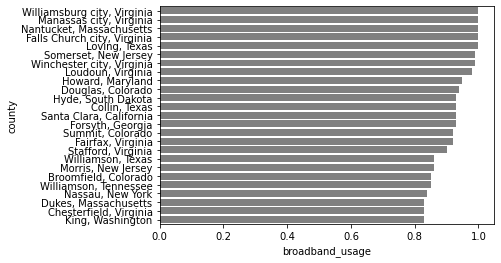

In [90]:
top_plotter(bband_cty, 25, 'broadband_availability_per_fcc', plot = 'bar')
top_plotter(bband_cty, 25, 'broadband_usage', plot = 'bar')

In [104]:
# top_plotter(bband_cty, 25, 'broadband_usage', plot = 'point')
top_plotter(bband_cty, 40, 'broadband_availability_per_fcc', plot = 'point')

> <ipython-input-102-ea38cc82af1c>(5)top_plotter()
      3     import pdb; pdb.set_trace()
      4 
----> 5     df = df.sort_values(col_to_sort_by, ascending=ascending)
      6     df = df.head(how_many)
      7 

     county_name    state   fips  population_2017  \
0        Autauga  Alabama   1001            55390   
1        Baldwin  Alabama   1003           212521   
2        Barbour  Alabama   1005            25157   
3           Bibb  Alabama   1007            22550   
4         Blount  Alabama   1009            57787   
...          ...      ...    ...              ...   
3134  Sweetwater  Wyoming  56037            43464   
3135       Teton  Wyoming  56039            23384   
3136       Uinta  Wyoming  56041            20431   
3137    Washakie  Wyoming  56043             8010   
3138      Weston  Wyoming  56045             6968   

      broadband_availability_per_fcc  broadband_usage               county  
0                               0.81             0.28     Autauga, Alaba

BdbQuit: 

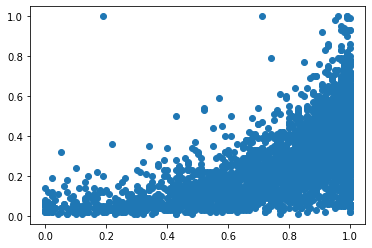

In [84]:
# dumb scatterplot
plt.scatter(x = bband['broadband_availability_per_fcc'],
                y = bband['broadband_usage'])
plt.show()


# making a map

,st,county_id,county_name,broadband_availability_per_fcc,broadband_usage
0,AL,1001,Autauga County,0.81,0.28
1,AL,1003,Baldwin County,0.88,0.30
2,AL,1005,Barbour County,0.59,0.18
3,AL,1007,Bibb County,0.29,0.07
4,AL,1009,Blount County,0.69,0.09
...,...,...,...,...,...
62,AL,1125,Tuscaloosa County,0.92,0.32
63,AL,1127,Walker County,0.76,0.22
64,AL,1129,Washington County,0.30,0.02
65,AL,1131,Wilcox County,0.42,0.03
